In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [5]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

In [7]:
def auc_pr(y_test, y_pred):
    precision, recall, th = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [8]:
scl = StandardScaler()
X = scl.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [12]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0
    
    for C_i in C_set:
        clf.C = C_i
        
        clf.fit(X_t, y_t)
        a_x = clf.predict(X_val)
        
        precision, recall, th = precision_recall_curve(y_val, a_x)
        
        auc_precision_recall = auc(recall, precision)
        
        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
            
    print("Подобранный параметр С:", C)
    return C
    

In [13]:
best_c_linearSVC = c_best_selection(np.arange(0.001, 100, 1), LinearSVC(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 41.00099999999999


In [14]:
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

In [15]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [18]:
print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.76502
AUC_PR: 0.82949


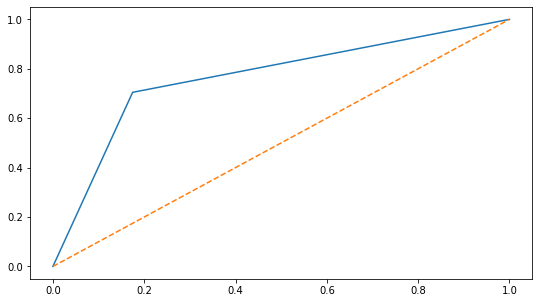

In [19]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle='--')

plt.show()

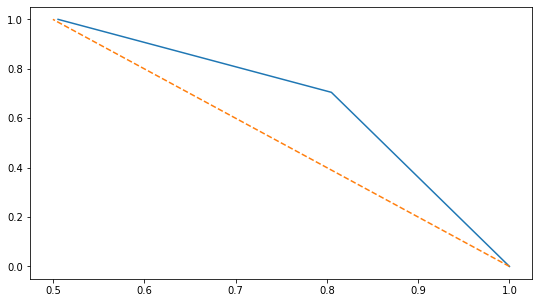

In [20]:
plt.figure(figsize=(9,5))

plt.plot(precision, recall, label="PR")
plt.plot([1, 0.5],[0,1], linestyle='--')

plt.show()

In [21]:
best_c_LR = c_best_selection(np.arange(0.001, 100, 1), LogisticRegression(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 1.001


In [22]:
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.77134
AUC_PR: 0.83116


[UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

In [53]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [54]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [55]:
df.shape

(41188, 21)

In [56]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

In [57]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

In [58]:
df.shape

(41188, 21)

In [59]:
df.drop(columns = 'duration', inplace = True)

In [34]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [36]:
enc = OrdinalEncoder()

In [37]:
data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])

clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [38]:
df_ = pd.DataFrame({'name': ['n', 'n', 'v', 'm', 'v', 'n']})

In [40]:
df_

,name
0,n
1,n
2,v
3,m
4,v
5,n


In [39]:
enc.fit_transform(df_)

array([[1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [1.]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [48]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OrdinalEncoder:', time.time()-start_time)
print('AUC-PR на OrdinalEncoder = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OrdinalEncoder: 1.0587232112884521
AUC-PR на OrdinalEncoder = 0.95339
Кол-во столбцов 19


In [43]:
model

Pipeline(steps=[('enc_and_st_scaler',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.conf.idx',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                (

In [65]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [66]:
enc = OneHotEncoder(handle_unknown="ignore")

data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [68]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OHE:', time.time()-start_time)
print('AUC-PR на OHE = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OHE: 1.20009183883667
AUC-PR на OHE = 0.95339
Кол-во столбцов 62


In [69]:
data = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [70]:
start_time = time.time()

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_train = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0] / X_train[X_train[col] == categ].shape[0]
        X_train.loc[X_train[col] == categ, col] = g_train
        
        
        g_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0] / X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_test 

      

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 1.8284711837768555
AUC-PR при mean-target encoding = 0.95312
Кол-во столбцов  19


In [71]:
start_time = time.time()
for col in cat:
    X_train[col] += np.random.rand(X_train.shape[0]) * np.sign(np.random.rand(X_train.shape[0]) - 0.5) / 10
    X_test[col] += np.random.rand(X_test.shape[0]) * np.sign(np.random.rand(X_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.7310504913330078
AUC-PR при mean-target encoding и шуме= 0.95217
Кол-во столбцов  19


In [72]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [73]:
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [74]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.851219892501831
AUC-PR при global mean = 0.95536


In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [83]:
print('Кол-во уникальных возрастов', df['age'].nunique())

Кол-во уникальных возрастов 78


In [84]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [85]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 2.380887508392334
AUC-PR при global mean = 0.96042


In [53]:
X = df

In [54]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'month', 'day_of_week',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [86]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])

df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [87]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [59]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [88]:
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [90]:
X_train.shape

(28831, 52)

In [91]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

auc_pr_lr_ohe = auc_pr(y_test, a_x)

In [92]:
print("AUC_PR = %.5f" % auc_pr_lr_ohe)

AUC_PR = 0.95221


In [97]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time()-start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время обучения модели 0.927950382232666
AUC_PR = 0.95188


In [98]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])

df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [99]:
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [100]:
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

In [101]:
X_train

,10,11,12,13,14,15,16,17,18,0_blue-collar,0_entrepreneur,0_housemaid,0_management,0_retired,0_self-employed,0_services,0_student,0_technician,0_unemployed,0_unknown,1_married,1_single,1_unknown,2_basic.6y,2_basic.9y,2_high.school,2_illiterate,2_professional.course,2_university.degree,2_unknown,3_unknown,3_yes,4_unknown,4_yes,5_unknown,5_yes,6_telephone,7_aug,7_dec,7_jul,7_jun,7_mar,7_may,7_nov,7_oct,7_sep,8_mon,8_thu,8_tue,8_wed,9_nonexistent,9_success
0,37,-0.567466,0.196418,-0.351015,-2.213588,2.249459,-1.599578,-1.669748,-2.061837,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,30,-0.567466,0.196418,1.665344,-1.131825,0.477886,0.781528,-1.563255,-2.419431,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,57,-0.203565,0.196418,-0.351015,-0.113695,-0.321482,-0.647481,0.233315,0.399899,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,46,-0.567466,0.196418,1.665344,-1.195458,-1.228873,-1.17796,-1.352571,-0.93521,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,55,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.719154,0.845855,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,55,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.718579,0.845855,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
28827,32,-0.567466,0.196418,-0.351015,0.840802,0.953186,-0.225863,0.778445,0.845855,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
28828,35,0.160335,0.196418,-0.351015,0.840802,-0.472714,0.593182,0.774991,0.845855,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
28829,48,-0.567466,0.196418,-0.351015,-1.195458,-1.228873,-1.17796,-1.313427,-0.93521,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [102]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [103]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.9550931453704834
AUC-PR (40 признаков) = 0.95290
indices = Int64Index([48,  7, 20, 22, 26, 17, 31,  0, 33, 35, 19, 18, 12,  3, 11, 29, 39,
            10, 34, 32, 14, 40,  1, 24, 37, 28, 15, 46,  8, 25,  2, 44,  9, 30,
            27, 45, 36, 42, 43,  4],
           dtype='int64')


In [85]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])

df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [91]:
from math import sqrt

In [ ]:
df = pd.read_csv('bank-additional-full.csv', sep=';')


X = df.drop(columns=['duration', 'y'])


df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')


cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns


X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns


scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

In [ ]:
df = pd.read_csv('bank-additional-full.csv', sep=';')


X = df.drop(columns=['duration', 'y'])


df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')


cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns


X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns


scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_


X_train_3 = pd.DataFrame()
X_test_3 = pd.DataFrame()
X_valid_3 = pd.DataFrame()